In [1]:
import os
from matplotlib import pyplot as plt
import cv2 as cv2
import numpy as np

from mrcs_loader import get_all_imgs_from_paths, get_files_of_type_from_path, load_paths_into_array
from Featurizer import Featurizer, FeatureEnsembler
import ImageTransforms
from GBDT import GBDTWrapper
from sklearn.preprocessing import StandardScaler

%matplotlib notebook

# Log
- Tried feature extraction + modelling with the full images (not lowpass filtered). This substantially lowered accuracy. AUCs of 0.55 without image transforms and 0.71 with image transforms.
- Calculate confusion matrix, how much do we care about false negatives?

In [2]:
# Data path
data_path = '../data/raw/'

# Paths of good/bad .mrcs files
good_path_in = os.path.join(data_path, 'job028/micrographs')
bad_path_in = os.path.join(data_path, 'job031/micrographs')

data_file_ext = '.mrcs'
fileFilter = lambda x: 'lowpass' in x

data_paths = {'good': get_files_of_type_from_path(good_path_in, data_file_ext, fileFilter),  
              'bad': get_files_of_type_from_path(bad_path_in, data_file_ext, fileFilter)}

data_raw = {'good': get_all_imgs_from_paths(data_paths['good']),
        'bad': get_all_imgs_from_paths(data_paths['bad'])}

In [3]:
data = data_raw['good']+data_raw['bad']
labels = np.append(np.ones(len(data_raw['good'])), np.zeros(len(data_raw['bad'])))

In [4]:
def preprocessData(raw):
    # Stack into contiguous array
    data = np.stack(raw, axis=0)
        
    # Flatten
    raw_data_shape = data.shape
    data = data.reshape(raw_data_shape[0], -1)
        
    # Zero-mean and unit-variance rescaling
    scaler = StandardScaler()
    scaler.fit(data)
    data = scaler.transform(data)
    data = data.reshape(raw_data_shape)
    return data

In [5]:
def stack_imgrid(data, nrows, ncols, start = 0):
    total, height, width = data.shape
    return  data[start:start+nrows*ncols]\
            .reshape(nrows,ncols, height, width)\
            .swapaxes(1,2)\
            .reshape(height*nrows, width*ncols)

def plot_grid(data, nrows, ncols, start = 0):
    total, height, width = data.shape
    plt.imshow(
        data[start:start+nrows*ncols]
            .reshape(nrows,ncols, height, width)
            .swapaxes(1,2)
            .reshape(height*nrows, width*ncols)
        , cmap='gray'
    )

In [6]:
norm_data = preprocessData(data)
bf_data = np.array([ cv2.bilateralFilter(x, 6, 75, 75) for x in norm_data ])

<IPython.core.display.Javascript object>


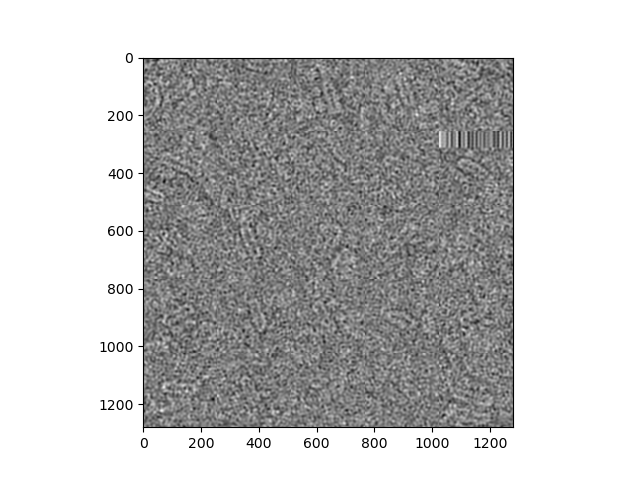

In [15]:
plt.figure()
plot_grid(norm_data, 5, 5, start = 0)

In [7]:
imcmp = np.append(
    stack_imgrid(norm_data, 3, 3, 0),
    stack_imgrid(bf_data, 3, 3, 0),
    axis = 1
)

<IPython.core.display.Javascript object>


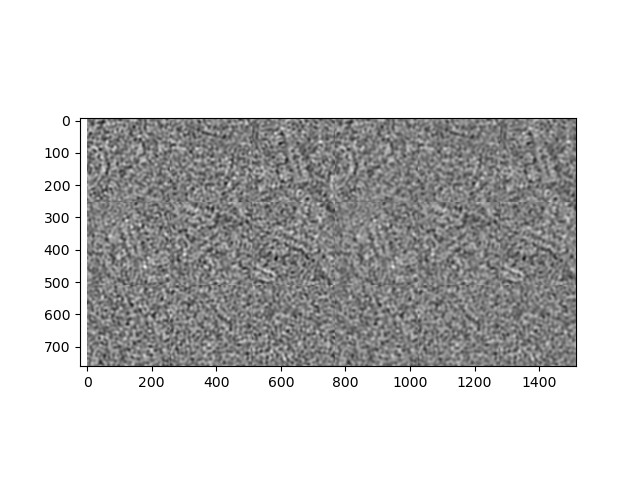

In [8]:
plt.figure()
plt.imshow(imcmp, cmap='gray')

In [10]:
import pywt

<IPython.core.display.Javascript object>


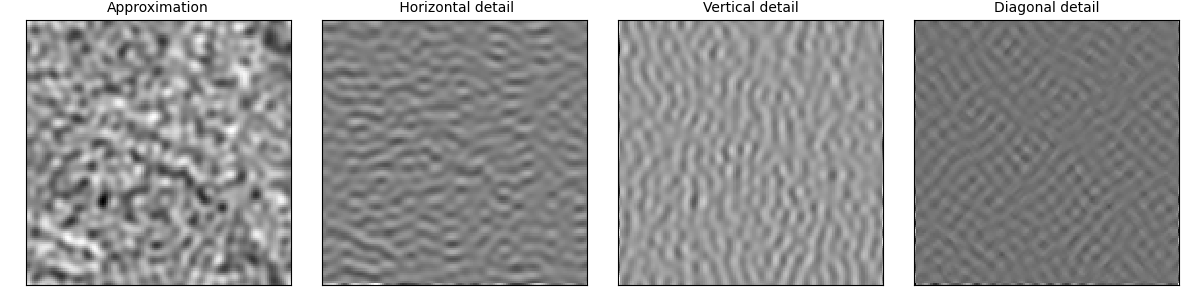

In [26]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

coeffs2 = pywt.dwt2(norm_data[5], 'sym2')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


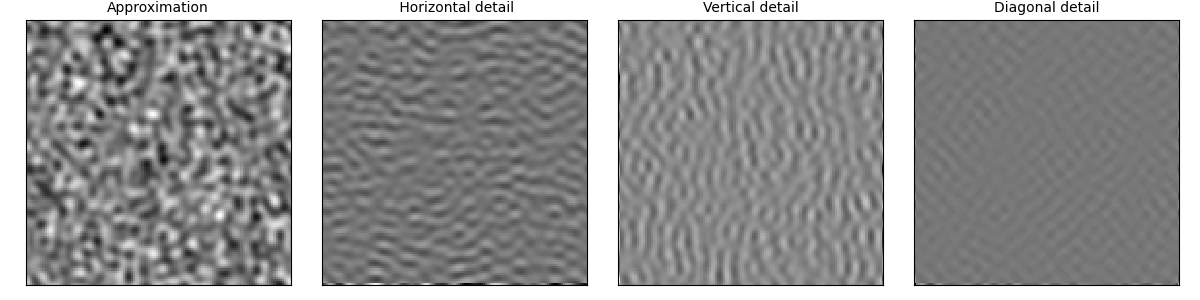

In [27]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

coeffs2 = pywt.dwt2(norm_data[1500], 'sym2')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

# Modelling

In [ ]:
# Get features
F = Featurizer(data, n_components=6)
F.fit()

# Build model
LGB_params = params={
            "objective" : "binary",
            "metric" : "auc",
            "boosting": 'gbdt',
            "max_depth" : -1,
            "learning_rate" : 0.01,
            "verbosity" : 1,
            "seed": 0
            }
G = GBDTWrapper(F.feature_coeffs, labels, params=LGB_params)
G.train()
G.plotROC()

Preprocessing data . . .
Fitting estimators . . .
Calculating 6 features using PCA...
	Time taken = 1.686s
Calculating 6 features using FastICA...
	Time taken = 10.750s
Calculating 6 features using FactorAnalysis...
	Time taken = 104.215s
Calculating features . . .
Done!
Training GBDT . . .


In [ ]:
lr_probs = G.model.predict(G.X_test)
cm = confusion_matrix(G.y_test, lr_probs)

Applying transform: Identity
Preprocessing data . . .
Fitting estimators . . .
Calculating 21 features using PCA...
	Time taken = 29.768s
Calculating 21 features using FastICA...
	Time taken = 10.966s
Calculating 21 features using FactorAnalysis...
	Time taken = 240.101s
Calculating features . . .
Done!
Applying transform: Roberts
Preprocessing data . . .
Fitting estimators . . .
Calculating 21 features using PCA...
	Time taken = 0.022s
Calculating 21 features using FastICA...
	Time taken = 0.238s
Calculating 21 features using FactorAnalysis...
	Time taken = 0.068s
Calculating features . . .
Done!
Applying transform: FFT2
Preprocessing data . . .
Fitting estimators . . .
Calculating 21 features using PCA...
	Time taken = 0.086s
Calculating 21 features using FastICA...
	Time taken = 0.832s
Calculating 21 features using FactorAnalysis...
	Time taken = 0.178s
Calculating features . . .
Done!
Training GBDT . . .
Done!


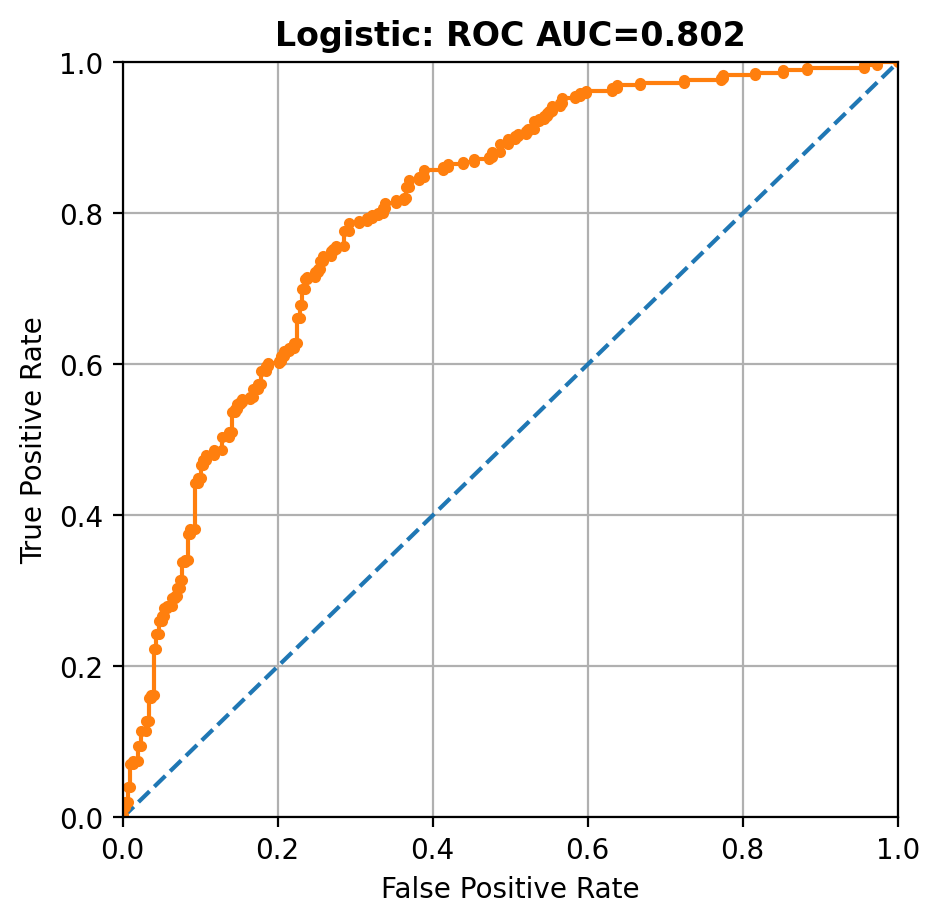

In [28]:
# List of transforms to apply, we include the identity transform
transforms = [
              ImageTransforms.IdentityTransform(), 
              ImageTransforms.RobertsTransform(), 
              ImageTransforms.FFT2Transform(),
             ]
ensembler = FeatureEnsembler(data, transforms, n_components=21)
ensembler.fit()

# Build model
G = GBDTWrapper(ensembler.feature_coeffs, labels)
G.train()
G.plotROC()